In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import logging
import numpy as np
import seaborn as sns
import index_definition
import index_utils as ai
from confidence_index import plot_confidence_index
import warnings
import common

# 忽略所有警告
warnings.filterwarnings("ignore")
logging.basicConfig(
    level=logging.INFO,  
    format='%(asctime)s [简记] %(message)s',  # 去除非必要字段
    handlers=[
        logging.StreamHandler(), 
        logging.FileHandler('data_analysis.log') 
    ]
)

In [ ]:
## Analyse How long holding the attack will produce a goal



# unified the coordinate system, based on the home team



#home_team_id = data[data['ishomegame'] == 1]['teamid'].unique()

# 填充缺失值
def fill_team_possession_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    fill the missing values in the team possession column
    :param df: 
    :return: 
    """
    def fill_missing_values(row):
        if  (row['eventname'] != 'faceoff') and row['compiledgametime'] == row['pre_time'] and pd.isna(row['teaminpossession']):
            return [row['pre_teaminpossession'] ,row['pre_currentpossession']]
        # elif row['eventname'] == 'faceoff' and int(row['compiledgametime']) == 0:
        #     return [math.nan, math.nan]
        elif  (row['eventname'] != 'faceoff') and  (pd.isna(row['teaminpossession'])) and row['pre_teaminpossession'] == row['after_teaminpossession']:
            return [row['pre_teaminpossession'] ,row['pre_currentpossession']]
        # elif row['eventname'] == 'faceoff' and (pd.isna(row['teaminpossession'])) and row['pre_teaminpossession'] != row['after_teaminpossession']:
        #     return [row['after_teaminpossession'], row['after_currentpossession']]
        else:
            return [row['teaminpossession'], row['currentpossession']]
               
    df_copy = df.copy()
    df_copy['pre_teaminpossession'] = df_copy['teaminpossession'].shift(1)
    df_copy['pre_currentpossession'] = df_copy['currentpossession'].shift(1)
    df_copy['pre_time'] = df_copy['compiledgametime'].shift(1)
    df_copy['after_teaminpossession'] = df_copy['teaminpossession'].shift(-1)
    df_copy['after_currentpossession'] = df_copy['currentpossession'].shift(-1)
    df_copy[['teaminpossession','currentpossession']] = df_copy[['teaminpossession','currentpossession','eventname','pre_time','compiledgametime','pre_teaminpossession','after_teaminpossession','after_currentpossession','pre_currentpossession']].apply(fill_missing_values,axis=1,result_type='expand')
    df_copy.drop(columns=['pre_teaminpossession', 'pre_currentpossession','pre_time','after_teaminpossession', 'after_currentpossession' ],inplace=True)
    return df_copy
   

def calculate_control_rate(data: pd.DataFrame, gameid: str) -> None:
    """
    calculate the control rate of the home team in the game
    :param data: 
    :param gameid: 
    :return: 
    """
    df = data.copy()
    # get the data for the specific game
    df = df[df['gameid'] == gameid]
    # order the data by time
    df = df.sort_values("compiledgametime")
    # obtain the team in possession
    possession_changes = df[df["teaminpossession"].notna()]
    times = possession_changes["compiledgametime"].values
    teams = possession_changes["teamid"].values.astype(int)
    
    # 计算控球时间分布
    total_time = df["compiledgametime"].max()
    bins = range(0, int(total_time)+10, 10)  # 每10秒为一个区间
    team814_time = [0] * len(bins)
    team885_time = [0] * len(bins)
    
    current_team = None
    prev_time = 0
    
    for time, team in zip(times, teams):
        idx = int(prev_time // 10)
        if current_team is not None:
            duration = time - prev_time
            if current_team == 814:
                team814_time[idx] += duration
            else:
                team885_time[idx] += duration
        current_team = team
        prev_time = time
    
    # 计算控球率
    possession_ratio = [
        (t814 / (t814 + t885)) * 100 if (t814 + t885) > 0 else 50
        for t814, t885 in zip(team814_time, team885_time)
    ]
    
    # 绘制曲线
    plt.figure(figsize=(12, 6))
    plt.plot(bins[:-1], possession_ratio, label="Team 814 Possession (%)")
    plt.xlabel("Game Time (seconds)")
    plt.ylabel("Possession Rate (%)")
    plt.title("Possession Ratio Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

In [2]:
data = pd.read_csv("Linhac24-25_Sportlogiq.csv")
data['inopponentarea'] = data.apply(common.puck_location, axis=1)

In [ ]:



#data.to_csv('hockey.csv')

ai.plot_attack_index_time(data, 60592, 503, index_definition.STRENGTH_EVENTS, 15, 0, 3600)
ai.plot_attack_index_time(data, 60592, 524, index_definition.STRENGTH_EVENTS, 15, 0, 3600)

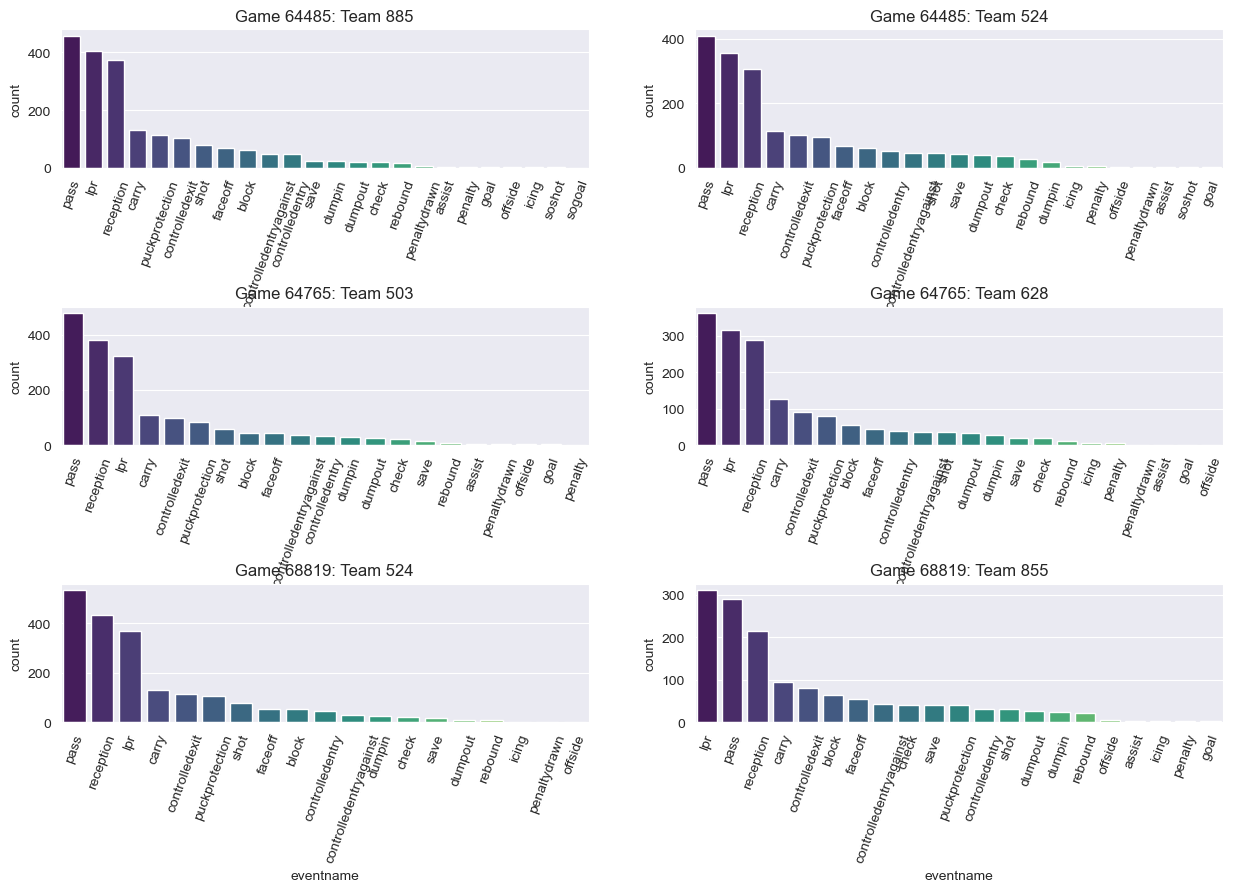

In [20]:
#单独分析比赛 68819
games = [64485,64765,68819]
max_cols = 2 #每行最多显示2张
num_plots = 2 * len(games)
rows = (num_plots + max_cols - 1) // max_cols
cols = min(max_cols, num_plots)
plt.figure(figsize=(15, rows * 3))
for j in range(len(games)):
    gameid  = games[j]
    game_df = data[data['gameid'] == gameid]
    teams = game_df['teamid'].unique()
    for i in range(len(teams)):
        teamid = teams[i]
        team_df = game_df[game_df['teamid'] == teamid]
        res_df = pd.DataFrame()
        for event in index_definition.STRENGTH_EVENTS:
            condition = team_df.eval(event)
            condition_df = team_df[condition]
            res_df = condition_df if res_df.empty else pd.concat([res_df, condition_df],axis=0)
        ax = plt.subplot(rows, cols, i + 2*j + 1)
        plt.subplots_adjust(hspace=1)  # 值在 0 到 1 之间，值越大行间距越大
       # value_counts = res_df['eventname'].value_counts()
       # sns.countplot(x='eventname', data=res_df, order=value_counts.index, palette="viridis",ax=ax)
        value_counts = team_df['eventname'].value_counts()
        sns.countplot(x='eventname', data=team_df, order=value_counts.index, palette="viridis",ax=ax)

        plt.xticks(rotation=70)
        plt.title('Game {}: Team {}'.format(gameid,teamid))

plt.show()





主队平均控球时间：4.675897435897418
客队平均控球时间：4.395555555555551
主队平均控球时间：5.705100835294106
客队平均控球时间：4.923001225611358
主队平均控球时间：5.430431893687707
客队平均控球时间：4.0433644859812965
主队平均控球时间：4.072449516981121
客队平均控球时间：5.314433235433079


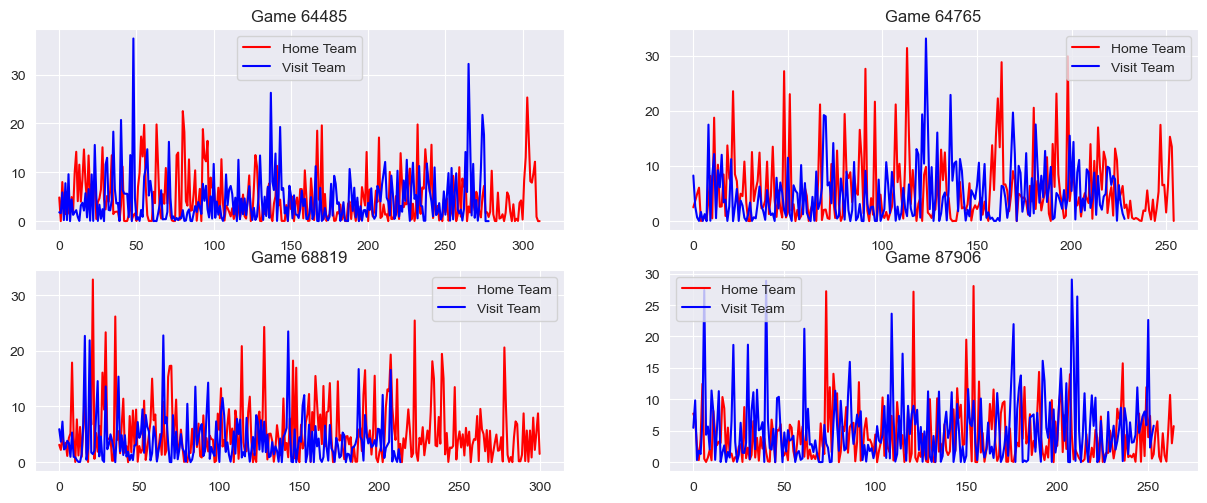

In [17]:

games = [64485, 64765,68819,87906]
max_cols = 2  #每行最多显示2张
num_plots = 2 * len(games)
rows = (num_plots + max_cols - 1) // max_cols
cols = min(max_cols, num_plots)
plt.figure(figsize=(15, rows * 3))
for j in range(len(games)):
    gameid = games[j]
    home_control_rate, visit_control_rate, home_max_control_time, visit_max_control_time = common.get_control_rate0(data, gameid)
    print("主队平均控球时间：" + str(sum(home_max_control_time) / len(home_max_control_time)))
    print("客队平均控球时间：" + str(sum(visit_max_control_time) / len(visit_max_control_time)))

    # plt.scatter( x=range(len(home_max_control_time)),y=list(home_max_control_time),marker='o',label='Home Team')
    # plt.scatter(x=range(len(visit_max_control_time)),y=list(visit_max_control_time),marker='x',label='Visit Team')
    ax = plt.subplot(rows, cols, j + 1)
    sns.lineplot(x=range(len(home_max_control_time)), y=list(home_max_control_time), color='r', label='Home Team',
                 ax=ax)
    sns.lineplot(x=range(len(visit_max_control_time)), y=list(visit_max_control_time), color='b', label='Visit Team',
                 ax=ax)
    plt.legend()
    plt.title('Game {}'.format(gameid))
plt.show()
